# Natural Language Processing

O objetivo deste notebook é a criação de um modelo de Machine Learning de analise de sentimento (classificação) utilizado o processamento de linguagem natural. O modelo irá classificar os comentários em duas classes: "Other" e "Negativo". O conjunto de comentários negativos possui um alto valor de informação para empresas, podendo ser utilizado como feedback de melhoria e/ou base de dados para análise de causa raiz. 

## 1. Importando Bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import spacy
from nltk import tokenize, RSLPStemmer, FreqDist, tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.lm import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, make_scorer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from string import punctuation
from time import time
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from gensim.models.word2vec import Word2Vec
from collections import defaultdict
from yellowbrick.classifier import ROCAUC
from sklearn.preprocessing import LabelEncoder
from yellowbrick.classifier import PrecisionRecallCurve


from utils.regex_utils import *
from utils.stopword_utils import RemoverStopwords
from utils.normalize_utils import ProcessoNormalizacao
from utils.stemming_utils import ProcessoStemming
from utils.n_grams_utils import ngrams_count
from utils.wordcloud_utils import nuvem_palavras
from utils.select_model_utils import print_score_BayesSearchCV, print_score
from utils.features_extract import ExtracaoFeatures, E2V_IDF, extract_features_from_corpus, cut_off
from utils.word2vec_utils import E2V_IDF
from utils.lemmatization_utils import ProcessoLemmatization

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brothers\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. Leitura dos dados

In [3]:
dataset = pd.read_csv('datasets/order_reviews.csv', sep=';')
# Removendo colunas desnecessárias
dataset.drop(['review_id', 'review_creation_date', 'review_answer_timestamp', 'review_comment_title', 'order_id'], axis=1, inplace=True)

# Retirando o valores Null de reviews
dataset = dataset.dropna()
dataset = dataset.reset_index(drop=True)
dataset.head()

,review_score,review_comment_message
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa
2,4,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes do prazo."


Com objetivo de criar um modelo de análise sentimental em uma abordagem de Machine Learning supervisionado, iremos dividir os sentimentos em duas classes: negativo e positivo. O database não possui uma definição explicita sobre a definição de sentimento para cada comentário. Pensando em uma implementação rápida, utilizaremos a coluna "review_score" para rotular os dados já que ela dá uma uma ideia sobre a satisfação do cliente a respeito da compra.

Rotulagem dos dados:
- other (0): Compreende os scores de valores 3, 4 e 5
- Negativo (1): Compreende os scores de valores 1 e 2 

In [15]:
# Rotulagem dos dados
score_map = {
    1: 'negativo',
    2: 'negativo',
    3: 'other',
    4: 'other',
    5: 'other'
}

dataset['sentiment_label'] = dataset['review_score'].map(score_map)
dataset = dataset[['review_score', 'sentiment_label','review_comment_message']]
dataset.head()

,review_score,sentiment_label,review_comment_message
0,5,other,Recebi bem antes do prazo estipulado.
1,5,other,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa
2,4,other,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho
3,4,other,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,other,"Vendedor confiável, produto ok e entrega antes do prazo."


## 4. Criando uma BaseLine

In [17]:
# Vetorizando as 50 palavras com mais ocorrência da coluna "review_comment_message"
vetorizar = CountVectorizer(max_features=50)
bag_of_words = vetorizar.fit_transform(dataset['review_comment_message'])
bag_of_words.shape

(40977, 50)

In [13]:
regressao_logistica = LogisticRegression(solver = "liblinear")
scorer = make_scorer(f1_score, average = 'weighted')
scores = cross_val_score(regressao_logistica, bag_of_words, dataset['sentiment_label'], cv=10, scoring=scorer)
print(f'f1_score:{np.sort(scores)}')
print(f'Média: {scores.mean()}')
print(f'Desvio Padrão: {scores.std()}')

f1_score:[0.83418187 0.83511699 0.83635938 0.83728349 0.8379938  0.84055531
 0.84080667 0.84271239 0.8444404  0.85408984]
Média: 0.8403540126956498
Desvio Padrão: 0.005546679441664567


#### 4.2.1. Matriz de confusão

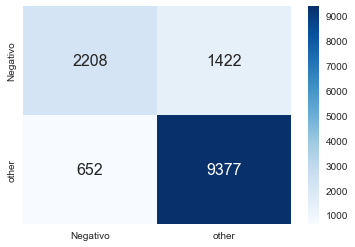

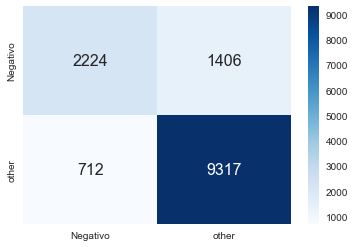

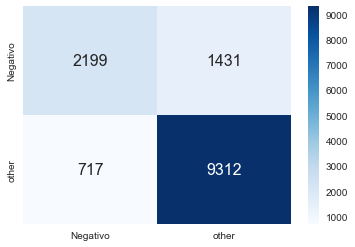

In [20]:
X = bag_of_words
y = dataset['sentiment_label']

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)
i = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "liblinear")

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    conf_matrix = confusion_matrix(y_test, y_pred)

    df_cm = pd.DataFrame(conf_matrix, index=['Negativo', 'other'], columns=['Negativo', 'other'])
    plt.figure(i, figsize=(6, 4))
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="Blues", fmt='g')
    i += i

#### 4.2.4. Analise precisão, revocação e pontuação (f1) para cada classe:

In [21]:
# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "liblinear")

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.8419579351381881
              precision    recall  f1-score   support

    negativo       0.77      0.61      0.68      3630
       other       0.87      0.93      0.90     10029

    accuracy                           0.85     13659
   macro avg       0.82      0.77      0.79     13659
weighted avg       0.84      0.85      0.84     13659

f1_score: 0.8393355001432357
              precision    recall  f1-score   support

    negativo       0.76      0.61      0.68      3630
       other       0.87      0.93      0.90     10029

    accuracy                           0.84     13659
   macro avg       0.81      0.77      0.79     13659
weighted avg       0.84      0.84      0.84     13659

f1_score: 0.8368673455770317
              precision    recall  f1-score   support

    negativo       0.75      0.61      0.67      3630
       other       0.87      0.93      0.90     10029

    accuracy                           0.84     13659
   macro avg       0.81      0.77      0.

## 5. Estrutura do Pipeline de trasformação dos dados

Será utilizado a classe Pipeline do Scikit Learn para executar uma preparação dos textos de cada comentário de forma automática, deixando pronto para treinamento e previsão do rótulo de sentimento. As etapas do pipeline são:

- Remoção das expressões regulares: sabendo que os dados são fruto de comentários da internet, será necessário lidar com algumas expressões regulares. Iremos realizar o pré-processamento dos dados, substituído as expressões regulares por termos que as caracterizem de forma simples;

- Remoção de StopWords: As stopwords são palavras que não apresentam relevância em determinado contexto e podem ser removidas sem perda semântica da frase;

- Normalização dos comentários: pega os dados Unicode e tenta representá-los em caracteres ASCII (ou seja, os caracteres universalmente exibíveis entre 0x00 e 0x7F), onde os compromissos assumidos ao mapear entre dois conjuntos de caracteres são escolhidos para estar perto do que um humano com um teclado americano escolheria;

- Técnicas para reduzir formas flexionais das palavras:

    - Stemming: Stemming é a técnica que transforma as flexões de uma palavra em um núcleo comum (tronco).  Essa técnica normaliza as palavras de forma a evitar suas flexões e derivações. Existem diversos algoritmos para realizar a “stemmização", seja em Português, sejam em outros idiomas;

    - Lemmatization: buscar reduzir a palavra à sua raiz, retirando todas as inflexões e chegando ao lemma. Porém, essa redução sempre resultará em uma palavra que realmente existe na gramática. Outro ponto importante é que, nessa técnica, a classe gramatical da palavra será levada em consideração para fazer a redução;

- Extração de features: A extração de features de texto envolve resumir automaticamente o texto e encontrar palavras importantes. A extração de palavras poderá ser feita de duas formas:
    - TF-IDF (Term Frequency-Inverse Document Frequency): é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico.  O TF-IDF irá contar a frequência das palavras e atribui pesos as mesmas, ponderando-as em todo o dataset. Se uma palavra aparece muitas vezes, ela perde o poder de diferenciação, logo, possuirá um peso menor.


Todas as etapas do Pipeline foram modularizadas no diretório utils para tornar o programa mais "limpo".

## 6. Modelos de Classificação de Sentimento

Criação dos dados pelo processo de Stemming:

In [4]:
# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}

vectorizer = TfidfVectorizer(min_df=15) 

# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('stemming', ProcessoStemming(RSLPStemmer())),
    ('text_features', ExtracaoFeatures(vectorizer))
])

# Dfinido X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'other', 4: 'other', 5: 'other'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values

# Aplicando o pipeline
X_processed = text_pipeline.fit_transform(X)

Criação dos dados pelo processo de Lemmatization:

In [ ]:
# definindo X e y 
comentarios = dataset['review_comment_message'].dropna().index
score = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'other', 4: 'other', 5: 'other'})

# Dfinido X e y 
X = list(dataset['review_comment_message'][comentarios].values)
y = score.values


# Definindo todas as trafomações regex para serem aplicadas ao pipeline
regex_transformers = {
    'datas': re_dates,
    'valores_dinheiro': re_money,
    'numeros': re_numbers,
    'negacoes': re_negation,
    'caracteres_especiais': re_special_chars,
    'espacos_branco': re_whitespaces
}

vectorizer = TfidfVectorizer(min_df=15) 

# Criando o Pipeline
text_pipeline = Pipeline([
    ('regex', RemoverRegex(regex_transformers)),
    ('stopwords', RemoverStopwords(stopwords.words('portuguese'))),
    ('normalization', ProcessoNormalizacao()),
    ('lemmatization', ProcessoLemmatization())
])

# Aplicando o pipeline
X_processed_lemma = text_pipeline.fit_transform(X)

# Devido o processo ser muito demorado, vamos salvar os dados em um arquivo 
dataset['review_lemma'] = X_processed_lemma
dataset.to_csv('order_review_lemma.csv', sep=';', index=False)

### 6.1. LogisticRegression

In [6]:
# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_processed, y)


for train_index, test_index in skf.split(X_processed, y):
    X_train, X_test = X_processed[train_index], X_processed[test_index]
    y_train, y_test = y[train_index], y[test_index]

    regressao_logistica = LogisticRegression(solver = "liblinear", random_state=42)
    
    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.8890892846443671
              precision    recall  f1-score   support

    negativo       0.80      0.78      0.79      3630
       other       0.92      0.93      0.93     10029

    accuracy                           0.89     13659
   macro avg       0.86      0.85      0.86     13659
weighted avg       0.89      0.89      0.89     13659

f1_score: 0.8926657233601832
              precision    recall  f1-score   support

    negativo       0.80      0.80      0.80      3630
       other       0.93      0.93      0.93     10029

    accuracy                           0.89     13659
   macro avg       0.86      0.86      0.86     13659
weighted avg       0.89      0.89      0.89     13659

f1_score: 0.8912287659889376
              precision    recall  f1-score   support

    negativo       0.80      0.79      0.79      3630
       other       0.92      0.93      0.93     10029

    accuracy                           0.89     13659
   macro avg       0.86      0.86      0.

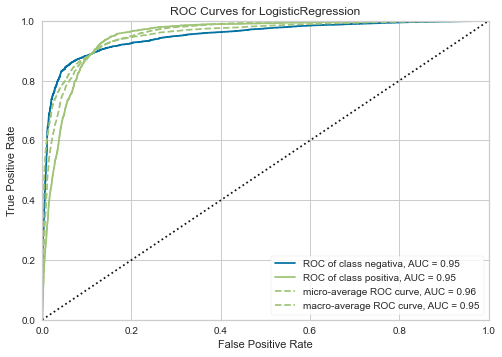

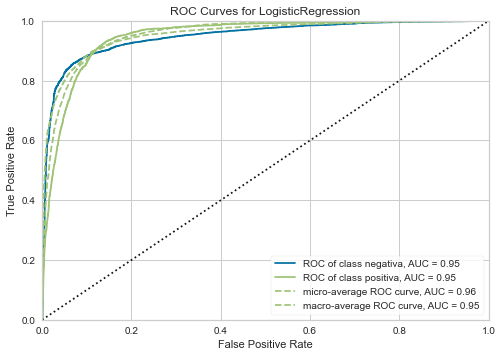

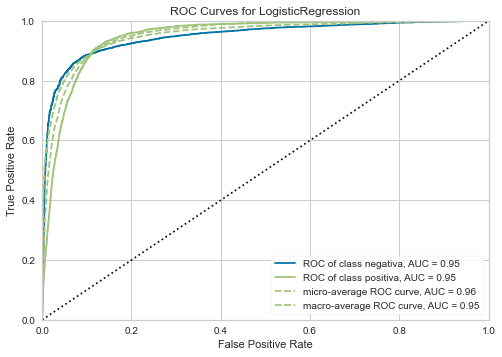

In [6]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed
y = dataset['review_score'][comentarios].map({1: 1, 2: 1, 3: 0, 4: 0, 5: 0})  # 1 -> Negativo; 0 -> Others


# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)
i = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "liblinear")

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    visualizer = ROCAUC(regressao_logistica, classes=["negativa", "positiva"])

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and render the figure
    i += i

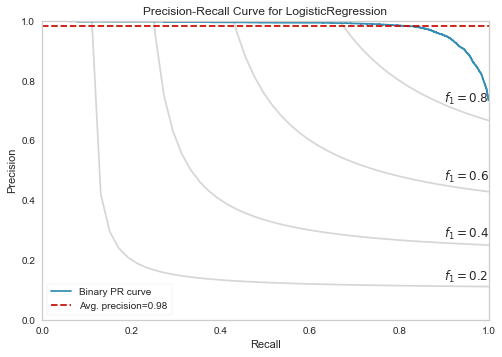

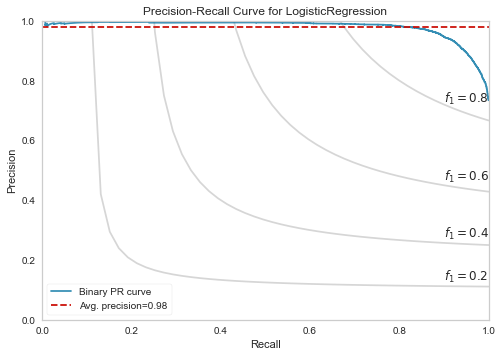

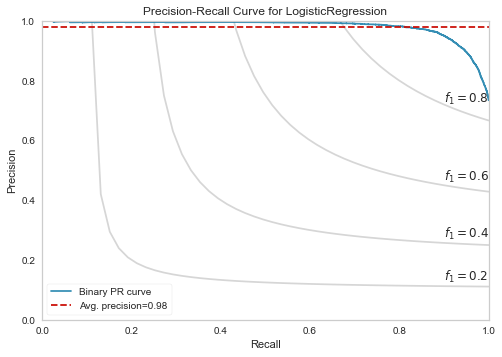

In [5]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed
encoder = LabelEncoder()
y_encoder = encoder.fit_transform(y)

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y_encoder)
i = 1

for train_index, test_index in skf.split(X, y_encoder):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoder[train_index], y_encoder[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(solver = "liblinear")

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    # Create the visualizer, fit, score, and show it
    viz = PrecisionRecallCurve(
        regressao_logistica,
        classes=encoder.classes_,
            iso_f1_curves=True,
            per_class=True,
            micro=False
    )
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()                     # Finalize and render the figure
    i += i

#### 6.1.2. Otimizando os hiperparamentors do modelo de LogisticRegression (Stemming)

A classe BayesSearchCV é uma otimização Bayesiana sobre hiperparâmetros. Os parâmetros do estimador usados ​​para aplicar esses métodos são otimizados por pesquisa de validação cruzada sobre configurações de parâmetros. Ao contrário do GridSearchCV, nem todos os valores de parâmetro são testados, mas um número fixo de configurações de parâmetro é amostrado das distribuições especificadas. O número de configurações de parâmetro que são tentadas é dado por n_iter.

In [7]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed
y = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'other', 4: 'other', 5: 'other'}) 

search_spaces=[{
  'C': Real(1e-2, 1e+2, prior='log-uniform'),
  'penalty': Categorical(['l2', 'none']),
  'solver': Categorical(['lbfgs', 'sag']),
  'class_weight': Categorical(['balanced', None]),
  'random_state': [42],
  'max_iter': Integer(100, 1000, prior='log-uniform') 
}, {
  'C': Real(1e-2, 1e+2, prior='log-uniform'),
  'penalty': Categorical(['l1', 'l2']),
  'solver': Categorical(['liblinear']),
  'class_weight': Categorical(['balanced', None]),
  'random_state': [42],
  'max_iter': Integer(100, 1000, prior='log-uniform') 
}]

n_iter = 80
model = LogisticRegression()
incial = time()
print_score_BayesSearchCV(model, X, y, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 

Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 3.094228717450785), ('class_weight', None), ('max_iter', 1000), ('penalty', 'l2'), ('solver', 'liblinear')])
f1_score (weighted): 0.8934138677892681

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.79      0.80      0.79      2151
       other       0.93      0.92      0.93      6045

    accuracy                           0.89      8196
   macro avg       0.86      0.86      0.86      8196
weighted avg       0.89      0.89      0.89      8196

Tempo de execução: 75.7869353969892min


Comparando as duas formas de vetorização dos reviews, percebemos que o melhor modelo para o LogisticRegression é utilizando o TfidfVectorizer. Esta conclusão foi tomanda olhando não só as métricas (precision, recall e f1-score), mas também a rápida convergencia do modelo, onde o TfidfVectorizer convergiu com um número máximo de 100 iterações, enquanto o CountVectorizer convergiu com 1000.

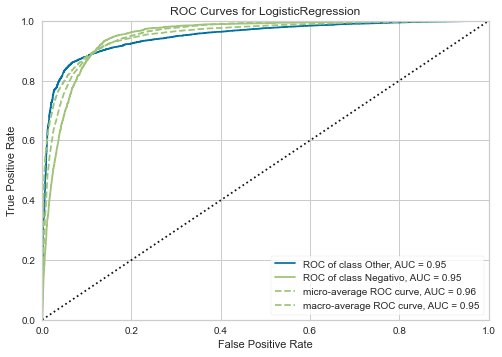

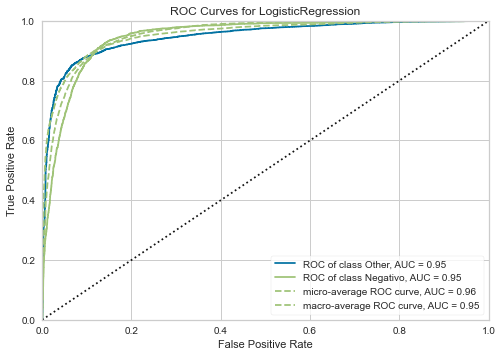

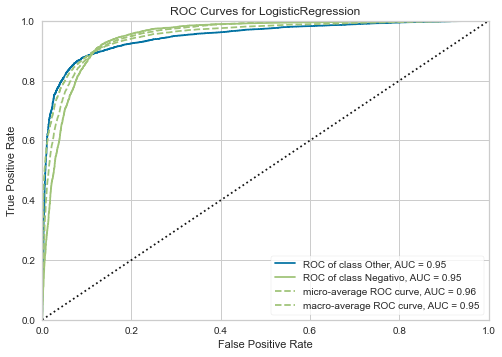

In [14]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed
y = dataset['review_score'][comentarios].map({1: 1, 2: 1, 3: 0, 4: 0, 5: 0})    # 1 -> Negativo; 0 -> Others

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)
i = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(C= 3.094228717450785,class_weight=None, max_iter=1000, penalty='l2', solver = "liblinear", random_state=42)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    visualizer = ROCAUC(regressao_logistica, classes=['Other','Negativo'])

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and render the figure
    i += i

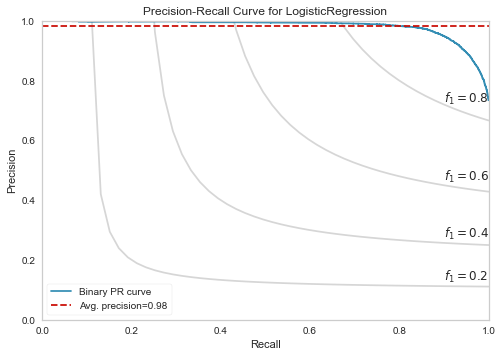

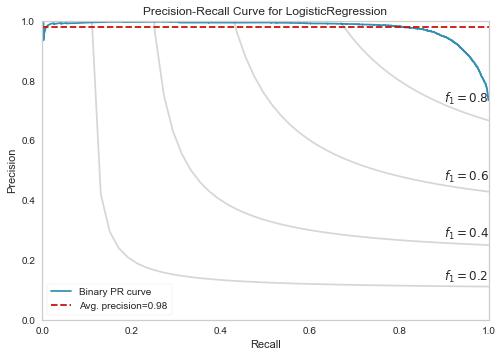

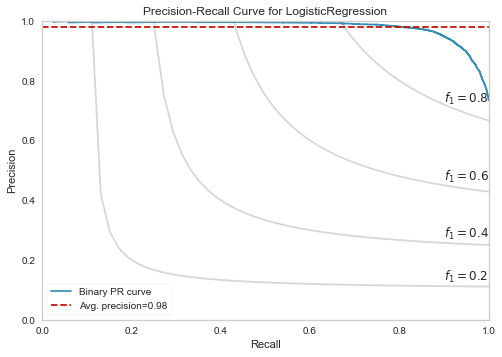

In [6]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed
encoder = LabelEncoder()
y_encoder = encoder.fit_transform(y)

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y_encoder)
i = 1

for train_index, test_index in skf.split(X, y_encoder):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoder[train_index], y_encoder[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(C= 3.094228717450785,class_weight=None, max_iter=1000, penalty='l2', solver = "liblinear", random_state=42)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    # Create the visualizer, fit, score, and show it
    viz = PrecisionRecallCurve(
        regressao_logistica,
        classes=encoder.classes_,
            iso_f1_curves=True,
            per_class=True,
            micro=False
    )
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()                     # Finalize and render the figure
    i += i

#### 6.1.3. Otimizando os hiperparamentors do modelo de LogisticRegression (lemmatization)

In [4]:
dataset_lemma = pd.read_csv('datasets/order_review_lemma.csv', sep=';')
dataset_lemma = dataset_lemma.dropna().reindex()

# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15)    
corpus_features_lemma, df_corpus_features_lemma = extract_features_from_corpus(dataset_lemma['review_lemma'], vectorizer, df=True)
y = dataset_lemma['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'other', 4: 'other', 5: 'other'}) 
print(f'Shape: {df_corpus_features_lemma.shape}')
df_corpus_features_lemma

Shape: (40817, 1367)


,2e,abaixo,abraco,abri,abril,abrir,absurdo,acabado,acabamento,acabar,...,voce,volta,voltagem,voltar,voltarar,volume,whey,xl,zero,ziper
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = df_corpus_features_lemma
y = dataset_lemma['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'other', 4: 'other', 5: 'other'}) 

search_spaces=[{
  'C': Real(1e-2, 1e+2, prior='log-uniform'),
  'penalty': Categorical(['l2', 'none']),
  'solver': Categorical(['lbfgs', 'sag']),
  'class_weight': Categorical(['balanced', None]),
  'random_state': [42],
  'max_iter': Integer(100, 1000, prior='log-uniform') 
}, {
  'C': Real(1e-2, 1e+2, prior='log-uniform'),
  'penalty': Categorical(['l1', 'l2']),
  'solver': Categorical(['liblinear']),
  'class_weight': Categorical(['balanced', None]),
  'random_state': [42],
  'max_iter': Integer(100, 1000, prior='log-uniform') 
}]

n_iter = 80
model = LogisticRegression()
incial = time()
print_score_BayesSearchCV(model, X, y, search_spaces, n_iter)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros: 

Melhor conjunto de parâmetros encontrado: 

OrderedDict([('C', 2.740484492317098), ('class_weight', None), ('max_iter', 907), ('penalty', 'l2'), ('random_state', 42), ('solver', 'liblinear')])
f1_score (weighted): 0.8916791182369376

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.81      0.81      0.81      2179
       other       0.93      0.93      0.93      5985

    accuracy                           0.90      8164
   macro avg       0.87      0.87      0.87      8164
weighted avg       0.90      0.90      0.90      8164

Tempo de execução: 48.858470817406975min


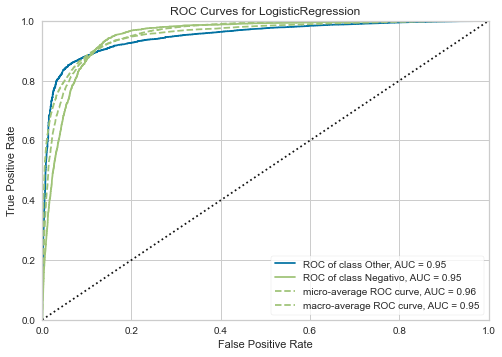

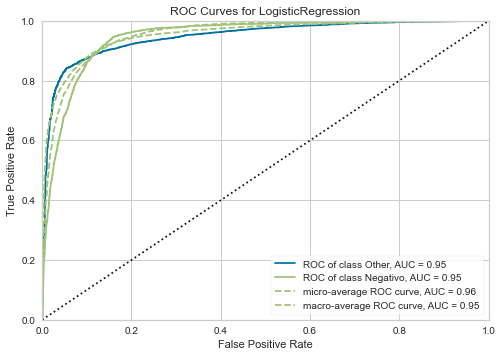

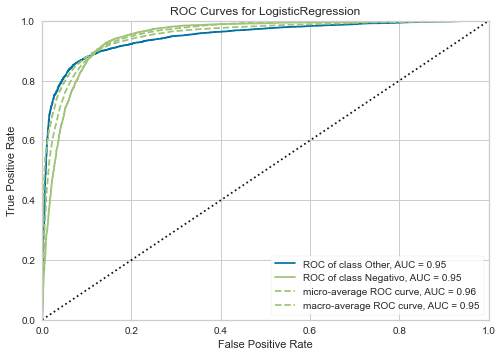

In [8]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = corpus_features_lemma
y = dataset_lemma['review_score'].map({1: 1, 2: 1, 3: 0, 4: 0, 5: 0})    # 1 -> Negativo; 0 -> Others

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)
i = 1

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(C=2.740484492317098,class_weight=None, max_iter=1000, penalty='l2', solver = "liblinear", random_state=42)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    visualizer = ROCAUC(regressao_logistica, classes=['Other','Negativo'])

    visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)        # Evaluate the model on the test data
    visualizer.show()                       # Finalize and render the figure
    i += i

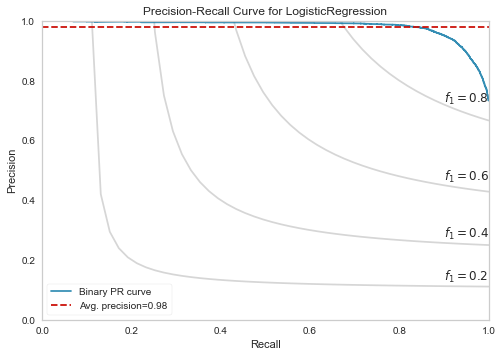

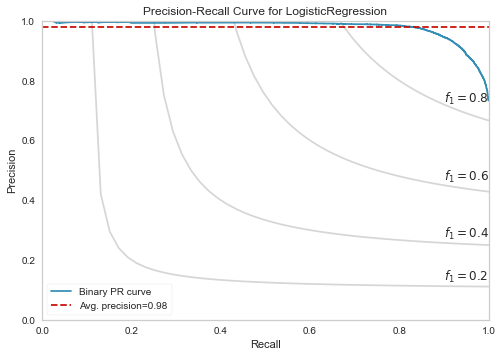

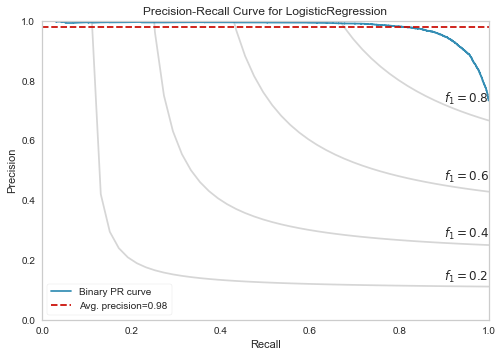

In [13]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = corpus_features_lemma
encoder = LabelEncoder()
y_encoder = encoder.fit_transform(y)

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y_encoder)
i = 1

for train_index, test_index in skf.split(X, y_encoder):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoder[train_index], y_encoder[test_index]

    #Criação do modelo
    regressao_logistica = LogisticRegression(C=1.1155578996339013,class_weight=None, max_iter=1000, penalty='l2', solver = "liblinear", random_state=42)

    regressao_logistica.fit(X_train, y_train)
    y_true, y_pred = y_test, regressao_logistica.predict(X_test)
    
    plt.figure(i)
    # Create the visualizer, fit, score, and show it
    viz = PrecisionRecallCurve(
        regressao_logistica,
        classes=encoder.classes_,
            iso_f1_curves=True,
            per_class=True,
            micro=False
    )
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()                     # Finalize and render the figure
    i += i

### 6.2. SVM (Support Vector Machines)

In [5]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = X_processed
y = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'other', 4: 'other', 5: 'other'}) 

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_processed, y)


for train_index, test_index in skf.split(X_processed, y):
    X_train, X_test = X_processed[train_index], X_processed[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = SVC(kernel="rbf", random_state=42)
    
    model.fit(X_train, y_train)
    y_true, y_pred = y_test, model.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.8989024781016146
              precision    recall  f1-score   support

    negativo       0.81      0.81      0.81      3630
       other       0.93      0.93      0.93     10029

    accuracy                           0.90     13659
   macro avg       0.87      0.87      0.87     13659
weighted avg       0.90      0.90      0.90     13659

f1_score: 0.900200672144533
              precision    recall  f1-score   support

    negativo       0.80      0.84      0.82      3630
       other       0.94      0.92      0.93     10029

    accuracy                           0.90     13659
   macro avg       0.87      0.88      0.87     13659
weighted avg       0.90      0.90      0.90     13659

f1_score: 0.900305624510054
              precision    recall  f1-score   support

    negativo       0.80      0.84      0.82      3630
       other       0.94      0.92      0.93     10029

    accuracy                           0.90     13659
   macro avg       0.87      0.88      0.87

In [8]:
dataset_lemma = pd.read_csv('datasets/order_review_lemma.csv', sep=';')
dataset_lemma = dataset_lemma.dropna().reindex()

# Será removido palavras em que possui menos de 5 ocorrências
vectorizer = TfidfVectorizer(min_df=15)     # , stop_words=stop_words
corpus_features_lemma, df_corpus_features_lemma = extract_features_from_corpus(dataset_lemma['review_lemma'], vectorizer, df=True)
y = dataset_lemma['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'other', 4: 'other', 5: 'other'}) 

In [9]:
# Atribuindo a X o valor que foi processado pelo Pipeline
X = corpus_features_lemma
y = dataset_lemma['review_score'].map({1: 'negativo', 2: 'negativo', 3: 'other', 4: 'other', 5: 'other'}) 

# Cria 3 partições com os dados de disponíveis
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = SVC(kernel="rbf", random_state=42)
    
    model.fit(X_train, y_train)
    y_true, y_pred = y_test, model.predict(X_test)
    score = f1_score(y_true, y_pred, average='weighted')
    print(f'f1_score: {score}')
    print(classification_report(y_true, y_pred))

f1_score: 0.8980063088057381
              precision    recall  f1-score   support

    negativo       0.81      0.81      0.81      3626
       other       0.93      0.93      0.93      9980

    accuracy                           0.90     13606
   macro avg       0.87      0.87      0.87     13606
weighted avg       0.90      0.90      0.90     13606

f1_score: 0.8987570017113217
              precision    recall  f1-score   support

    negativo       0.79      0.83      0.81      3627
       other       0.94      0.92      0.93      9979

    accuracy                           0.90     13606
   macro avg       0.87      0.88      0.87     13606
weighted avg       0.90      0.90      0.90     13606

f1_score: 0.8999735226979467
              precision    recall  f1-score   support

    negativo       0.80      0.83      0.82      3626
       other       0.94      0.92      0.93      9979

    accuracy                           0.90     13605
   macro avg       0.87      0.88      0.

#### 7.2.1. Otimização para Tf-id pelo GridSearchCV

In [6]:
# Definindo X e y
X = X_processed
y = dataset['review_score'][comentarios].map({1: 'negativo', 2: 'negativo', 3: 'other', 4: 'other', 5: 'other'}) 


# Hiperparâmentros
tuned_parameters = {
    'C': [1, 50, 100, 150],
    'kernel' : ['rbf'],
    'gamma': [0.1, 5] 
}

model_SVC = SVC()
incial = time()
print_score(model_SVC, X, y, tuned_parameters)
final = time()
print(f'Tempo de execução: {(final - incial) / 60}min')

# Ajustando hiperparâmetros para make_scorer(f1_score, average=micro)

Melhor conjunto de parâmetros encontrado: 

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Pontuações de grade no conjunto de desenvolvimento:

0.891 (+/-0.001) for {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
0.787 (+/-0.011) for {'C': 1, 'gamma': 5, 'kernel': 'rbf'}
0.891 (+/-0.001) for {'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}
0.801 (+/-0.012) for {'C': 50, 'gamma': 5, 'kernel': 'rbf'}
0.889 (+/-0.002) for {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
0.801 (+/-0.012) for {'C': 100, 'gamma': 5, 'kernel': 'rbf'}
0.887 (+/-0.002) for {'C': 150, 'gamma': 0.1, 'kernel': 'rbf'}
0.801 (+/-0.012) for {'C': 150, 'gamma': 5, 'kernel': 'rbf'}

Relatório de classificação detalhado para o melhor modelo:

              precision    recall  f1-score   support

    negativo       0.78      0.81      0.80      2151
       other       0.93      0.92      0.93      6045

    accuracy                           0.89      8196
   macro avg       0.8

## 8. Conclusão

Após verificar todas as métricas (precision,recall e f1-score) e o plot das curvas (ROC e PrecisionRecallCurve) verificamos que para classificação binária é possível criação de um modelo irá classificar os comentários em duas classes: "Other" e "Negativo" com boa precisão. O melhor desempenho obtido foi utilizando o processo de Lemmatization.

Hiperparâmetros:
LogisticRegression(C=1.1155578996339013,class_weight=None, max_iter=1000, penalty='l2', solver = "liblinear", random_state=42)
SVC(kernel="rbf", random_state=42)
